In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df = df.replace({"positive": 1, "negative": 0})

C:\Users\felik\AppData\Local\Temp\ipykernel_16424\3638722553.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"positive": 1, "negative": 0})


In [4]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Lets get started with some natural langauge processing!

In [5]:
def metrics(actual, predicted):
    # lengths must be the same
    if len(actual) != len(predicted):
        print("error lengths of actual and predicted are not the same.")
        return
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for a, p in zip(actual, predicted):
        if a == 1 and p == 1:
            true_positive += 1
        elif a == 0 and p == 0:
            true_negative += 1
        elif a == 0 and p == 1:
            false_positive += 1
        elif a == 1 and p == 0:
            false_negative += 1

    try:
        accuracy = (true_positive+true_negative)/len(predicted)
        precision = true_positive/(true_positive+false_positive)
        recall = true_positive/(true_positive+false_negative)
        f1 = 2*((precision*recall)/(precision+recall))
    except:
        raise ZeroDivisionError("Division by zero")

    print(f"accuracy:{accuracy:.4f}, Precision:{precision:.4f}, Recall:{recall:.4f}, F1:{f1:.4f}")




## Step one Linear Regression and Bag of Words!


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load data
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.2)

# Convert text to BoW features
vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train classifier
model = LogisticRegression()
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)

metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.8832, Precision:0.8782, Recall:0.8887, F1:0.8834


c:\Users\felik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Regression might be the simplest algorithm out there, but isn't it fantastic?

These values will be our baseline model! 

accuracy:0.8848, Precision:0.8804, Recall:0.8892, F1:0.8848

In [7]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

# Bayes expects "dense array"
X_train_dense = X_train_bow.toarray()
X_test_dense = X_test_bow.toarray()

model.fit(X_train_dense, y_train)

y_pred = model.predict(X_test_dense)

metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.7485, Precision:0.8198, Recall:0.6343, F1:0.7152


Maybe not super surprising Bayes might not be kitted for NLP!

One thing we have forgotten about is the data is binary! of course bayes doesn't work!

We could use an SVM, however because a SVM scales with $n_{features}*n^2_{samples}$ the computation is way to slow for my machine :(


## Next step Tfidvectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.8962, Precision:0.8874, Recall:0.9066, F1:0.8969


A new best model! 

How exiating our new best model is:

accuracy:0.8966, Precision:0.8827, Recall:0.9129, F1:0.8975

Let's try something intresting a PCA?

Problem the pca takes forever! lets try a Truncated SVD much like a PCA!

In [9]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=5, random_state=42)
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.fit_transform(X_test_vec)

model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)


metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.6031, Precision:0.5955, Recall:0.6327, F1:0.6135


Our worst model yet! 

accuracy:0.6012, Precision:0.5973, Recall:0.6271, F1:0.6118

Our data is highly dimentional removing the dimentions makes it worse. Who could have gussed.

These values are slightly better than a random guess which would be 50/50. 

Letter on in this project I will create my very own neural network and see if it outperforms a TruncatedSVD

## SentimentIntensityAnalyzer AKA pretrained model from NLTK

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
Semtiment = SentimentIntensityAnalyzer()


# Testing some obvious once before
print(f"first: {Semtiment.polarity_scores("If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!")}")
print(f"second: {Semtiment.polarity_scores(("Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."))}")
print(f"Third: {Semtiment.polarity_scores(("Besides being boring, the scenes were oppressive and dark. The movie tried to portray some kind of moral, but fell flat with its message. What were the redeeming qualities?? On top of that, I don't think it could make librarians look any more unglamorous than it did."))}")


first: {'neg': 0.094, 'neu': 0.531, 'pos': 0.375, 'compound': 0.9149}
second: {'neg': 0.166, 'neu': 0.662, 'pos': 0.172, 'compound': 0.2362}
Third: {'neg': 0.079, 'neu': 0.876, 'pos': 0.045, 'compound': -0.168}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\felik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
def vader_sentiment(text):
    score = Semtiment.polarity_scores(text)
    return 1 if score['neg'] < score["pos"] else 0

y_pred = X_test.apply(vader_sentiment)


metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.6926, Precision:0.6426, Recall:0.8622, F1:0.7364


In [12]:
def vader_sentiment2(text):
    score = Semtiment.polarity_scores(text)
    return 1 if score['compound'] > 0 else 0

y_pred = X_test.apply(vader_sentiment2)


metrics(y_test.tolist(), y_pred.tolist())


accuracy:0.6978, Precision:0.6481, Recall:0.8598, F1:0.7391


In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 4
drop_out_rate = 0.2
output_shape = 1
hiddenunits = 16
input_shape = 4 # components in the truncatedSVD 5 is the best

vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

svd = TruncatedSVD(n_components=input_shape, random_state=42)
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.fit_transform(X_test_vec)

X_train_tensor = torch.tensor(X_train_reduced, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_reduced, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tensor([ 0.2728, -0.0692,  0.0256,  0.0161, -0.0338], device='cuda:0')

In [105]:

class Neuralnet(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape,drop_out_rate):
        super().__init__()
        self.block_1 = nn.Sequential(nn.Linear(in_features=input_shape, out_features=hidden_units),
                                     nn.ReLU(),
                                    nn.Dropout(drop_out_rate))
        self.block_2 = nn.Sequential(nn.Linear(in_features=hidden_units, out_features=output_shape)
)
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        return x
    
model = Neuralnet(output_shape=output_shape, input_shape=input_shape, hidden_units=hiddenunits, drop_out_rate=drop_out_rate).to(device)

In [106]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss() #binary
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [107]:
num_epochs = 25
epoch_losses = []
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    
    for batch_X, batch_y in training_loader:
        optimizer.zero_grad()  # Reset gradients
        
        # Reshape
        batch_y = batch_y.view(-1, 1)
        
        predictions = model(batch_X)  # Forward pass
        loss = loss_fn(predictions, batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(training_loader)
    epoch_losses.append(avg_epoch_loss)
    if epoch % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")


Epoch [1/25], Loss: 0.6732
Epoch [6/25], Loss: 0.6580
Epoch [11/25], Loss: 0.6574
Epoch [16/25], Loss: 0.6574
Epoch [21/25], Loss: 0.6574


In [108]:
# eval
model.eval()

predictions = []
actuals = []

with torch.no_grad():  
    for batch_X, batch_y in zip(X_test_tensor, y_test_tensor):
        # Get model predictions
        output = torch.sigmoid(model(batch_X.unsqueeze(0)))  # Add batch dimension
        pred = (output > 0.5).float()  # Apply sigmoid and convert to 0 or 1
        
        predictions.append(pred.cpu().numpy().flatten())
        actuals.append(batch_y.cpu().numpy().flatten())

In [109]:
metrics(actuals, predictions)

accuracy:0.6108, Precision:0.6178, Recall:0.5724, F1:0.5942


In [110]:
# Save models
model_path = 'model1.pth'
torch.save(model.state_dict(), model_path)

Text(0, 0.5, 'loss')

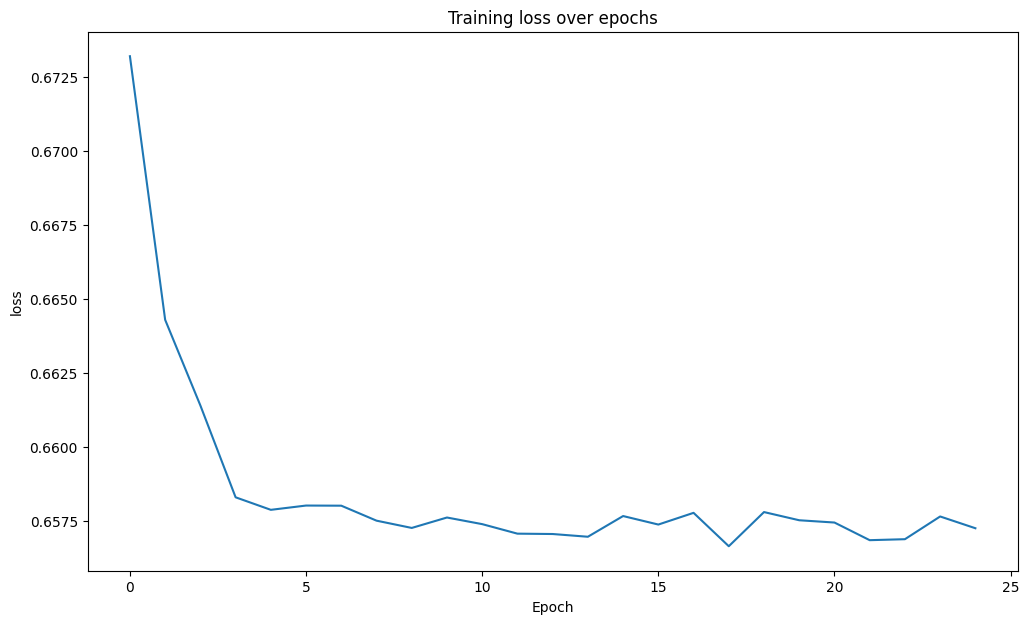

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))

plt.plot(range(len(epoch_losses)), epoch_losses)
plt.title("Training loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("loss")



In [98]:
len(epoch_losses)

250000